In [1]:
!pip install polyagamma pymc -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 4.5 MB/s eta 0:00:00


In [2]:
import time
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
from pymc.model.core import ImputationWarning
import arviz as az
import polyagamma
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional, Union, Tuple, Any, Protocol
from dataclasses import dataclass, field
from enum import Enum
import warnings
from scipy import stats
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from abc import ABC, abstractmethod

warnings.filterwarnings("ignore", category=ImputationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning, message=".*div*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*The effect of Potentials*")

In [3]:
def make_progress_callback(
    draws,
    tune,
    chains,
    print_every=100
):
    """
    Build a callback that prints progress every `print_every` iterations.
    """
    total = draws + tune
    start_times = {}

    def progress_cb(trace, draw):
        chain = draw.chain
        if chain not in start_times:
            start_times[chain] = time.time()
        elapsed = time.time() - start_times[chain]
        n = len(trace)

        if n % print_every == 0 or n == total:
            print(
                f"[Chain {chain+1}/{chains}] "
                f"draw {n}/{total}  "
                f"({elapsed:.1f}s elapsed)"
            )
            if n == total:
                print()

    return progress_cb

In [4]:
class VariableType(Enum):
    """Supported variable types for imputation"""
    CONTINUOUS = "continuous"
    BINARY = "binary"
    ORDINAL = "ordinal"
    CATEGORICAL = "categorical"
    COUNT = "count"
    TRUNCATED = "truncated"

In [5]:
@dataclass
class PredictorStats:
    """Statistics for predictor standardization"""
    mean: float
    std: float
    is_continuous: bool

In [6]:
@dataclass
class VariableSpec:
    """Specification for a variable in the imputation model"""
    name: str
    type: VariableType
    observed_data: np.ndarray
    missing_mask: np.ndarray
    prior_params: Optional[Dict[str, Any]] = None
    n_categories: Optional[int] = None
    lower_bound: Optional[float] = None
    upper_bound: Optional[float] = None
    exposure: Optional[np.ndarray] = None
    predictors: Optional[List[str]] = None
    predictor_stats: Dict[str, PredictorStats] = field(default_factory=dict)

In [7]:
class InputValidator:
    """Handles validation of input data and specifications"""
    def __init__(
        self,
        data: pd.DataFrame,
        variable_specs: Dict[str, VariableSpec]
    ):
        self.data = data
        self.variable_specs = variable_specs

    def validate(self):
        """Validate all inputs"""
        self._validate_variable_presence()
        self._validate_data_consistency()
        self._validate_predictors()
        self._validate_circular_dependencies()

    def _validate_variable_presence(self):
        """Check that all specified variables exist in data"""
        for var_name in self.variable_specs:
            if var_name not in self.data.columns:
                raise ValueError(f"Variable {var_name} not found in data")

    def _validate_data_consistency(self):
        """Check data consistency between specs and actual data"""
        for var_name, spec in self.variable_specs.items():
            data_array = self.data[var_name].values
            if not np.array_equal(spec.missing_mask, pd.isna(data_array)):
                warnings.warn(f"Missing mask for {var_name} doesn't match data NaNs")

    def _validate_predictors(self):
        """Check that all predictors are valid"""
        for var_name, spec in self.variable_specs.items():
            if spec.predictors:
                for pred in spec.predictors:
                    if pred not in self.variable_specs:
                        raise ValueError(f"Predictor {pred} for {var_name} not in variable specs")

    def _validate_circular_dependencies(self):
        """Check for circular dependencies in predictor structure"""
        for var_name, spec in self.variable_specs.items():
            if spec.predictors:
                self._check_circular_dependencies(var_name, spec.predictors, set())

    def _check_circular_dependencies(
        self,
        var: str,
        predictors: List[str],
        visited: set
    ):
        """Recursive check for circular dependencies"""
        if var in visited:
            raise ValueError(f"Circular dependency detected involving {var}")

        visited.add(var)
        for pred in predictors:
            if self.variable_specs[pred].predictors:
                self._check_circular_dependencies(pred, self.variable_specs[pred].predictors, visited)
        visited.remove(var)

In [8]:
class DependencyResolver:
    """Handles dependency resolution and topological sorting"""
    def __init__(
        self,
        variable_specs: Dict[str, VariableSpec]
    ):
        self.variable_specs = variable_specs

    def get_build_order(self) -> List[str]:
        """Get topologically sorted variable order"""
        # Build dependency graph
        in_degree = {var: 0 for var in self.variable_specs}
        adjacency = {var: [] for var in self.variable_specs}

        for var, spec in self.variable_specs.items():
            if spec.predictors:
                for pred in spec.predictors:
                    adjacency[pred].append(var)
                    in_degree[var] += 1

        # Kahn's algorithm
        queue = [var for var, degree in in_degree.items() if degree == 0]
        result = []

        while queue:
            var = queue.pop(0)
            result.append(var)

            for neighbor in adjacency[var]:
                in_degree[neighbor] -= 1
                if in_degree[neighbor] == 0:
                    queue.append(neighbor)

        if len(result) != len(self.variable_specs):
            raise ValueError("Circular dependency detected in variable relationships")

        return result

In [9]:
class PredictorStatisticsCalculator:
    """Calculates statistics for predictors"""
    @staticmethod
    def compute_statistics(variable_specs: Dict[str, VariableSpec]) -> None:
        """Compute and store statistics for all predictors"""
        for var_name, spec in variable_specs.items():
            if spec.predictors:
                for pred_name in spec.predictors:
                    pred_spec = variable_specs[pred_name]
                    obs_data = pred_spec.observed_data[~pred_spec.missing_mask]

                    if len(obs_data) > 0:
                        if pred_spec.type == VariableType.CONTINUOUS:
                            mean = np.mean(obs_data)
                            std = np.std(obs_data)
                            if std == 0:
                                std = 1.0
                            is_continuous = True
                        else:
                            mean = 0.0
                            std = 1.0
                            is_continuous = False
                    else:
                        mean = 0.0
                        std = 1.0
                        is_continuous = pred_spec.type == VariableType.CONTINUOUS

                    spec.predictor_stats[pred_name] = PredictorStats(
                        mean=mean, std=std, is_continuous=is_continuous
                    )

In [10]:
class PriorElicitor:
    """Handles prior elicitation based on observed data"""
    @staticmethod
    def get_default_priors(spec: VariableSpec) -> Dict[str, Any]:
        """Get sensible default priors based on variable type and observed data"""
        obs_data = spec.observed_data[~spec.missing_mask]

        if spec.type == VariableType.CONTINUOUS:
            if len(obs_data) > 0:
                return {
                    "mu_mean": np.mean(obs_data),
                    "mu_sd": np.std(obs_data) * 2,
                    "sigma_scale": np.std(obs_data)
                }
            else:
                return {"mu_mean": 0, "mu_sd": 10, "sigma_scale": 5}

        elif spec.type == VariableType.BINARY:
            if len(obs_data) > 0:
                p_obs = np.mean(obs_data)
                p_obs = np.clip(p_obs, 0.01, 0.99)
                alpha = max(p_obs * 10, 1)
                beta = max((1 - p_obs) * 10, 1)
                return {"alpha": alpha, "beta": beta, "p_obs": p_obs}
            else:
                return {"alpha": 1, "beta": 1, "p_obs": 0.5}

        elif spec.type in [VariableType.ORDINAL, VariableType.CATEGORICAL]:
            return {"dirichlet_alpha": np.ones(spec.n_categories)}

        elif spec.type == VariableType.COUNT:
            if len(obs_data) > 0:
                return {
                    "lambda_mean": max(np.mean(obs_data), 0.1),
                    "lambda_sd": max(np.std(obs_data), 1)
                }
            else:
                return {"lambda_mean": 1, "lambda_sd": 5}

        elif spec.type == VariableType.TRUNCATED:
            return {
                "mu_mean": (spec.lower_bound + spec.upper_bound) / 2,
                "mu_sd": (spec.upper_bound - spec.lower_bound) / 4,
                "sigma_scale": (spec.upper_bound - spec.lower_bound) / 6
            }

In [11]:
class LinearPredictorBuilder:
    """Builds linear predictors for regression models"""
    def __init__(self, variable_specs: Dict[str, VariableSpec]):
        self.variable_specs = variable_specs

    def build(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Dict[str, pm.Distribution],
        prior_params: Dict[str, Any],
        n_obs: int,
        all_continuous: bool = False,
        intercept_name: str = "intercept",
        coef_name: str = "beta",
        base_intercept: float = 0.0,
        base_intercept_sd: float = 2.0
    ) -> pt.TensorVariable:
        """Build linear predictor - FIXED version"""
        # Initialize with intercept
        if intercept_name:
            if "mu_mean" in prior_params:
                alpha = pm.Normal(f"{name}_{intercept_name}", prior_params["mu_mean"], prior_params["mu_sd"])
            else:
                alpha = pm.Normal(f"{name}_{intercept_name}", base_intercept, base_intercept_sd)
            linear_pred = pt.ones(n_obs) * alpha
        else:
            linear_pred = pt.zeros(n_obs)

        # Collect all predictor terms
        predictor_terms = []

        for pred_name, pred_var in predictors.items():
            pred_representations = self._get_predictor_representation(
                pred_name, pred_var, spec, all_continuous
            )
            pred_stats = spec.predictor_stats[pred_name]
            pred_spec = self.variable_specs[pred_name]

            if pred_spec.type == VariableType.CATEGORICAL:
                n_cat_pred = len(pred_representations)

                # For categorical predictors, exclude the first category (reference)
                if n_cat_pred > 1:
                    # Stack all but the first category
                    cat_matrix = pt.stack(pred_representations[1:], axis=1)
                    # cat_matrix shape: (n_obs, n_cat_pred-1)
                    # Create coefficients for all but the reference category
                    n_coef = n_cat_pred - 1
                    beta_cat = pm.Normal(
                        f"{name}_beta_{pred_name}_cat",
                        0, 1,
                        shape=n_coef  # Use n_coef instead of (n_cat_pred-1)
                    )

                    # Shapes should match: (n_obs, n_coef) @ (n_coef,) = (n_obs,)
                    term = pm.math.dot(cat_matrix, beta_cat)
                    predictor_terms.append(term)
            else:
                # Numeric predictors
                pred_rep = pred_representations[0]
                if pred_stats.is_continuous:
                    standardized = (pred_rep - pred_stats.mean) / pred_stats.std
                    coef_sd = 0.5
                else:
                    standardized = pred_rep
                    coef_sd = 1.0

                beta = pm.Normal(f"{name}_beta_{pred_name}", 0, coef_sd)
                predictor_terms.append(beta * standardized)

        # Vectorized sum of all terms
        if predictor_terms:
            linear_pred = linear_pred + pm.math.sum(
                pt.stack(predictor_terms, axis=0),
                axis=0
            )

        return linear_pred

    def _get_predictor_representation(
        self,
        pred_name: str,
        pred_var: pm.Distribution,
        spec: VariableSpec,
        all_continuous: bool
    ) -> List[pm.Distribution]:
        """Get appropriate representation of a predictor variable"""
        pred_spec = self.variable_specs[pred_name]

        if pred_spec.type == VariableType.CATEGORICAL:
            if all_continuous:
                pred_indicators = []
                for k in range(pred_spec.n_categories):
                    if pred_var.ndim == 2:
                        pred_k = pred_var[:, k]
                    else:
                        pred_k = pm.math.eq(pred_var, k).astype('float32')
                    pred_indicators.append(pred_k)
                return pred_indicators
            else:
                # For standard model, convert to one-hot
                pred_indicators = []
                for k in range(pred_spec.n_categories):
                    pred_k = pm.math.eq(pred_var, k).astype('float32')
                    pred_indicators.append(pred_k)
                return pred_indicators

        # For non-categorical predictors, return as-is
        return [pred_var]

In [12]:
class VariableBuilder(ABC):
    """Abstract base class for variable builders"""
    def __init__(
        self,
        linear_predictor_builder: LinearPredictorBuilder,
        prior_elicitor: PriorElicitor
    ):
        self.linear_predictor_builder = linear_predictor_builder
        self.prior_elicitor = prior_elicitor

    @abstractmethod
    def build_standard(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Build standard PyMC variable"""
        pass

    @abstractmethod
    def build_all_continuous(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Build variable with continuous representation"""
        pass

    def _make_observed(self, spec: VariableSpec) -> np.ma.MaskedArray:
        """Create a masked-array for PyMC observed"""
        mask = spec.missing_mask
        raw = spec.observed_data

        if spec.type in (VariableType.CONTINUOUS, VariableType.TRUNCATED):
            arr = raw.astype(float)
            return np.ma.masked_array(arr, mask=mask)

        # For discrete types: build an integer array
        filled = np.zeros(raw.shape, dtype=int)
        nonmiss = ~mask
        filled[nonmiss] = raw[nonmiss].astype(int)
        return np.ma.masked_array(filled, mask=mask)

In [13]:
class ContinuousVariableBuilder(VariableBuilder):
    """Builds continuous variables"""
    def build_standard(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Build standard continuous variable"""
        obs = self._make_observed(spec)
        prior_params = spec.prior_params or self.prior_elicitor.get_default_priors(spec)
        n_obs = len(spec.observed_data)

        if predictors is None:
            mu = pm.Normal(f"{name}_mu", prior_params["mu_mean"], prior_params["mu_sd"])
            sigma = pm.HalfNormal(f"{name}_sigma", prior_params["sigma_scale"])
            mu_expanded = pm.Deterministic(f"{name}_mu_expanded", mu * pm.math.ones(n_obs))
            var = pm.Normal(name, mu_expanded, sigma, observed=obs, shape=n_obs)
        else:
            linear_pred = self.linear_predictor_builder.build(
                name, spec, predictors, prior_params, n_obs,
                all_continuous=False
            )
            mu = pm.Deterministic(f"{name}_mu", linear_pred)
            sigma = pm.HalfNormal(f"{name}_sigma", prior_params["sigma_scale"])
            var = pm.Normal(name, mu, sigma, observed=obs, shape=n_obs)

        return var

    def build_all_continuous(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Same as standard for continuous variables"""
        obs = self._make_observed(spec)
        prior_params = spec.prior_params or self.prior_elicitor.get_default_priors(spec)
        n_obs = len(spec.observed_data)

        if predictors is None:
            mu = pm.Normal(f"{name}_mu", prior_params["mu_mean"], prior_params["mu_sd"])
            sigma = pm.HalfNormal(f"{name}_sigma", prior_params["sigma_scale"])
            mu_expanded = pm.Deterministic(f"{name}_mu_expanded", mu * pm.math.ones(n_obs))
            var = pm.Normal(name, mu_expanded, sigma, observed=obs, shape=n_obs)
        else:
            linear_pred = self.linear_predictor_builder.build(
                name, spec, predictors, prior_params, n_obs,
                all_continuous=True
            )
            mu = pm.Deterministic(f"{name}_mu", linear_pred)
            sigma = pm.HalfNormal(f"{name}_sigma", prior_params["sigma_scale"])
            var = pm.Normal(name, mu, sigma, observed=obs, shape=n_obs)

        return var

In [14]:
class BinaryVariableBuilder(VariableBuilder):
    """Builds binary variables"""
    def build_standard(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Build standard binary variable"""
        obs = self._make_observed(spec)
        prior_params = spec.prior_params or self.prior_elicitor.get_default_priors(spec)
        n_obs = len(spec.observed_data)

        if predictors is None:
            p = pm.Beta(f"{name}_p", prior_params["alpha"], prior_params["beta"])
            var = pm.Bernoulli(name, p, observed=obs, shape=n_obs)
        else:
            p_obs = prior_params.get("p_obs", 0.5)
            logodds0 = np.log(p_obs / (1-p_obs))

            logit_p = self.linear_predictor_builder.build(
                name, spec, predictors, prior_params, n_obs,
                all_continuous=False,
                base_intercept=logodds0,
                base_intercept_sd=2
            )

            p = pm.Deterministic(f"{name}_p", pm.math.sigmoid(logit_p))
            var = pm.Bernoulli(name, p, observed=obs, shape=n_obs)

        return var

    def build_all_continuous(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Build binary variable with Polya-Gamma augmentation"""
        n_obs = len(spec.observed_data)
        prior_params = spec.prior_params or self.prior_elicitor.get_default_priors(spec)

        # Get empirical probability
        obs_data_clean = spec.observed_data[~spec.missing_mask]
        if len(obs_data_clean) > 0:
            p_empirical = float(np.mean(obs_data_clean))
            p_empirical = np.clip(p_empirical, 0.05, 0.95)
        else:
            p_empirical = 0.5

        init_logodds = float(np.log(p_empirical / (1 - p_empirical)))

        # Create pm.Data for masks and observed values
        obs_mask = ~spec.missing_mask

        # Prepare y_obs for the full array (vectorized)
        vals = spec.observed_data.copy()
        y_full = np.where(np.isnan(vals), p_empirical, np.clip(vals, 0, 1))

        # Convert to pm.Data with float32
        obs_mask_data = pm.Data(f"{name}_obs_mask", obs_mask.astype(np.float32))
        y_data = pm.Data(f"{name}_y_data", y_full.astype(np.float32))

        # Build psi (logits) - inline without Deterministic
        if predictors is not None:
            psi_raw = self.linear_predictor_builder.build(
                name, spec, predictors, prior_params, n_obs,
                all_continuous=True,
                base_intercept=init_logodds,
                base_intercept_sd=0.5
            )
            psi = pm.math.tanh(psi_raw / 4.0) * 4.0
        else:
            psi0 = pm.Normal(
                f"{name}_psi0",
                mu=init_logodds,
                sigma=0.5,
                initval=init_logodds
            )
            psi = psi0 * pm.math.ones(n_obs)

        # Polya-Gamma
        z_param = pm.math.abs(psi) + 0.1

        omega = pm.PolyaGamma(
            f"{name}_omega",
            h=1.0,
            z=z_param,
            shape=n_obs,
            initval=np.full(n_obs, 0.25, dtype=np.float32)
        )

        # Inline clipping
        omega_clipped = pm.math.clip(omega, 1e-3, 10.0)

        # Fully vectorized likelihood over entire array
        kappa = y_data - 0.5

        # Mask the contributions (missing values contribute 0)
        term1 = pm.math.sum(obs_mask_data * kappa * psi)
        term2 = -0.5 * pm.math.sum(obs_mask_data * omega_clipped * psi**2)

        pm.Potential(
            f"{name}_pg_likelihood",
            term1 + term2
        )

        # Only create Deterministic for the final output
        probs = pm.Deterministic(f"{name}_p", pm.math.sigmoid(psi))

        return probs

In [15]:
class OrdinalVariableBuilder(VariableBuilder):
    """Builds ordinal variables"""
    def build_standard(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Build standard ordinal variable"""
        obs = self._make_observed(spec)
        n_cat = spec.n_categories
        n_obs = len(spec.observed_data)

        if predictors is None:
            eta = pm.Normal(f"{name}_eta", 0, 1, shape=n_obs)
        else:
            eta = self.linear_predictor_builder.build(
                name, spec, predictors, {}, n_obs,
                all_continuous=False,
                base_intercept=0,
                base_intercept_sd=1
            )
            eta = pm.Deterministic(f"{name}_eta", eta)

        cutpoints_raw = pm.Normal(
            f"{name}_cutpoints_raw",
            mu=0,
            sigma=1,
            shape=n_cat - 1,
        )
        cutpoints = pm.Deterministic(
            f"{name}_cutpoints",
            pm.math.cumsum(pm.math.log1pexp(cutpoints_raw) + 0.1)
        )

        var = pm.OrderedLogistic(name, eta, cutpoints, observed=obs, shape=n_obs)
        return var

    def build_all_continuous(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Same as standard - OrderedLogistic is already continuous-friendly"""
        return self.build_standard(name, spec, predictors)

In [16]:
class CategoricalVariableBuilder(VariableBuilder):
    """Builds categorical variables"""
    def build_standard(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Build standard categorical variable"""
        obs = self._make_observed(spec)
        prior_params = spec.prior_params or self.prior_elicitor.get_default_priors(spec)
        n_obs = len(spec.observed_data)
        n_cat = spec.n_categories

        if predictors is None:
            p = pm.Dirichlet(f"{name}_p", prior_params["dirichlet_alpha"])
            var = pm.Categorical(name, p, observed=obs, shape=n_obs)
        else:
            # Vectorized multinomial logistic regression
            intercepts = pm.Normal(f"{name}_intercepts", 0, 2, shape=(n_cat-1,))

            # Build predictor matrix
            X_list = []
            for pred_name, pred_var in predictors.items():
                pred_representations = self.linear_predictor_builder._get_predictor_representation(
                    pred_name, pred_var, spec, all_continuous=False
                )
                for pred_rep in pred_representations:
                    X_list.append(pred_rep[:, None])

            if X_list:
                X = pt.concatenate(X_list, axis=1)
                n_predictors = X.shape[1]
                beta = pm.Normal(f"{name}_beta", 0, 1, shape=(n_predictors, n_cat-1))
                eta = pm.math.dot(X, beta) + intercepts[None, :]
            else:
                eta = intercepts[None, :] * pm.math.ones((n_obs, 1))

            eta_full = pt.concatenate([eta, pt.zeros((n_obs, 1))], axis=1)
            p = pm.Deterministic(f"{name}_p", pm.math.softmax(eta_full, axis=1))
            var = pm.Categorical(name, p, observed=obs, shape=n_obs)

        return var

    def build_all_continuous(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Build categorical variable with continuous probabilities"""
        return self.build_standard(name, spec, predictors)

In [17]:
class CountVariableBuilder(VariableBuilder):
    """Builds count variables"""
    def build_standard(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Build standard count variable"""
        obs = self._make_observed(spec)
        n_obs = len(spec.observed_data)

        # Get observed data stats
        obs_data = spec.observed_data[~spec.missing_mask]
        if len(obs_data) > 0:
            data_mean = np.mean(obs_data)
            data_var = np.var(obs_data)
            if data_mean > 0:
                overdispersion = max(data_var / data_mean, 1.01)
            else:
                overdispersion = 2.0
        else:
            data_mean = 1.0
            overdispersion = 2.0

        if predictors is None:
            log_mu = pm.Normal(f"{name}_log_mu", np.log(max(data_mean, 0.1)), 1)
            mu_raw = pm.math.exp(log_mu)
            mu = pm.Deterministic(f"{name}_mu", mu_raw * pm.math.ones(n_obs))
        else:
            intercept_prior = np.log(max(data_mean, 0.1))

            log_mu = self.linear_predictor_builder.build(
                name, spec, predictors, {}, n_obs,
                all_continuous=False,
                base_intercept=intercept_prior,
                base_intercept_sd=1
            )

            mu = pm.Deterministic(
                f"{name}_mu",
                pm.math.log1pexp(log_mu)
            )

        if spec.exposure is not None:
            mu = mu * spec.exposure

        if overdispersion > 1:
            alpha_prior = data_mean / (overdispersion - 1)
            alpha_nb = pm.Gamma(f"{name}_alpha", alpha=max(alpha_prior, 2), beta=1)
        else:
            alpha_nb = pm.Gamma(f"{name}_alpha", alpha=100, beta=1)

        var = pm.NegativeBinomial(name, mu=mu, alpha=alpha_nb, observed=obs, shape=n_obs)

        return var

    def build_all_continuous(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Build count variable with continuous latent-rate"""
        obs = self._make_observed(spec)
        n_obs = len(spec.observed_data)

        # Get observed data stats
        obs_data = spec.observed_data[~spec.missing_mask]
        if len(obs_data) > 0:
            data_mean = np.mean(obs_data)
            data_var = np.var(obs_data)
            if data_mean > 0 and data_var / data_mean > 1:
                overdispersion = data_var / data_mean
                log_rate_sd_est = np.sqrt((overdispersion - 1) / data_mean)
                log_rate_sd_est = np.clip(log_rate_sd_est, 0.1, 2.0)
            else:
                log_rate_sd_est = 0.5
        else:
            data_mean = 1.0
            log_rate_sd_est = 0.5

        # Build linear predictor
        if predictors is not None:
            intercept_prior = np.log(max(data_mean, 0.1))

            log_mu = self.linear_predictor_builder.build(
                name, spec, predictors, {}, n_obs,
                all_continuous=True,
                base_intercept=intercept_prior,
                base_intercept_sd=1
            )

            log_mu = pm.Deterministic(f"{name}_log_mu", log_mu)
        else:
            log_mu_mean = pm.Normal(
                f"{name}_log_mu_mean",
                mu=np.log(max(data_mean, 0.1)),
                sigma=1
            )
            log_mu = pm.Deterministic(
                f"{name}_log_mu",
                log_mu_mean * pm.math.ones(n_obs)
            )

        if spec.exposure is not None:
            exp_tv = pm.Data(f"{name}_exposure", spec.exposure.astype("float32"))
            log_mu = log_mu + pm.math.log(exp_tv)

        sigma_log_rate = pm.HalfNormal(
            f"{name}_sigma_log_rate",
            sigma=log_rate_sd_est
        )

        log_lambda = pm.Normal(
            f"{name}_log_lambda",
            mu=log_mu,
            sigma=sigma_log_rate,
            shape=n_obs
        )

        lambda_rate = pm.Deterministic(
            f"{name}_lambda",
            pm.math.exp(log_lambda)
        )

        # Poisson likelihood
        pm.Poisson(name, mu=lambda_rate, observed=obs, shape=n_obs)

        return lambda_rate

In [18]:
class TruncatedVariableBuilder(VariableBuilder):
    """Builds truncated variables"""
    def build_standard(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Build standard truncated variable"""
        obs = self._make_observed(spec)
        prior_params = spec.prior_params or self.prior_elicitor.get_default_priors(spec)
        n_obs = len(spec.observed_data)

        if predictors is None:
            mu = pm.Normal(f"{name}_mu", prior_params["mu_mean"], prior_params["mu_sd"])
            sigma = pm.HalfNormal(f"{name}_sigma", prior_params["sigma_scale"])
            mu_expanded = pm.Deterministic(f"{name}_mu_expanded", mu * pm.math.ones(n_obs))
        else:
            linear_pred = self.linear_predictor_builder.build(
                name, spec, predictors, prior_params, n_obs,
                all_continuous=False
            )

            mu_expanded = pm.Deterministic(f"{name}_mu", linear_pred)
            sigma = pm.HalfNormal(f"{name}_sigma", prior_params["sigma_scale"])

        var = pm.TruncatedNormal(
            name, mu_expanded, sigma,
            lower=spec.lower_bound,
            upper=spec.upper_bound,
            observed=obs,
            shape=n_obs
        )

        return var

    def build_all_continuous(
        self,
        name: str,
        spec: VariableSpec,
        predictors: Optional[Dict[str, pm.Distribution]] = None
    ) -> pm.Distribution:
        """Same as standard - already continuous"""
        return self.build_standard(name, spec, predictors)

In [19]:
class VariableBuilderFactory:
    """Factory for creating appropriate variable builders"""
    def __init__(
        self,
        linear_predictor_builder: LinearPredictorBuilder,
        prior_elicitor: PriorElicitor
    ):
        self.linear_predictor_builder = linear_predictor_builder
        self.prior_elicitor = prior_elicitor

        self.builders = {
            VariableType.CONTINUOUS: ContinuousVariableBuilder(
                linear_predictor_builder, prior_elicitor
            ),
            VariableType.BINARY: BinaryVariableBuilder(
                linear_predictor_builder, prior_elicitor
            ),
            VariableType.ORDINAL: OrdinalVariableBuilder(
                linear_predictor_builder, prior_elicitor
            ),
            VariableType.CATEGORICAL: CategoricalVariableBuilder(
                linear_predictor_builder, prior_elicitor
            ),
            VariableType.COUNT: CountVariableBuilder(
                linear_predictor_builder, prior_elicitor
            ),
            VariableType.TRUNCATED: TruncatedVariableBuilder(
                linear_predictor_builder, prior_elicitor
            )
        }

    def get_builder(self, var_type: VariableType) -> VariableBuilder:
        """Get appropriate builder for variable type"""
        if var_type not in self.builders:
            raise ValueError(f"Unknown variable type: {var_type}")
        return self.builders[var_type]

In [20]:
class ModelBuilder(ABC):
    """Abstract base class for model builders"""
    def __init__(
        self,
        variable_specs: Dict[str, VariableSpec],
        dependency_resolver: DependencyResolver,
        variable_builder_factory: VariableBuilderFactory
    ):
        self.variable_specs = variable_specs
        self.dependency_resolver = dependency_resolver
        self.variable_builder_factory = variable_builder_factory

    @abstractmethod
    def build(self) -> pm.Model:
        """Build PyMC model"""
        pass

In [21]:
class StandardModelBuilder(ModelBuilder):
    """Builds standard PyMC models"""
    def build(self) -> pm.Model:
        """Build standard PyMC model"""
        with pm.Model() as model:
            # Order variables by dependency
            ordered_vars = self.dependency_resolver.get_build_order()

            # Build each variable
            variables = {}
            for var_name in ordered_vars:
                spec = self.variable_specs[var_name]

                # Get predictors if any
                if spec.predictors:
                    predictors = {pred: variables[pred] for pred in spec.predictors}
                else:
                    predictors = None

                # Get appropriate builder
                builder = self.variable_builder_factory.get_builder(spec.type)

                # Build variable
                var = builder.build_standard(var_name, spec, predictors)
                variables[var_name] = var

        return model

In [22]:
class AllContinuousModelBuilder(ModelBuilder):
    """Builds models with continuous representations"""
    def build(self) -> pm.Model:
        """Build PyMC model with continuous representations"""
        with pm.Model() as model:
            # Order variables by dependency
            ordered_vars = self.dependency_resolver.get_build_order()

            # Build each variable
            variables = {}
            for var_name in ordered_vars:
                spec = self.variable_specs[var_name]

                # Get predictors if any
                if spec.predictors:
                    predictors = {pred: variables[pred] for pred in spec.predictors}
                else:
                    predictors = None

                # Get appropriate builder
                builder = self.variable_builder_factory.get_builder(spec.type)

                # Build variable with continuous representation
                var = builder.build_all_continuous(var_name, spec, predictors)
                variables[var_name] = var

        return model

In [23]:
class ModelFitter:
    """Handles model fitting"""
    def __init__(self, model: pm.Model, seed: int):
        self.model = model
        self.seed = seed

    def fit(
        self,
        draws: int = 2000,
        tune: int = 1000,
        chains: int = 4,
        target_accept: float = 0.9,
        all_continuous: bool = True,
        **kwargs
    ) -> az.InferenceData:
        """Fit the model using MCMC"""
        with self.model:
            # Prior predictive
            prior = pm.sample_prior_predictive(random_seed=self.seed)

            if all_continuous:
                # All variables are continuous or have continuous representations
                trace = pm.sample(
                    draws=draws,
                    tune=tune,
                    chains=chains,
                    target_accept=target_accept,
                    random_seed=self.seed,
                    progressbar=False,
                    callback=make_progress_callback(draws, tune, chains),
                    **kwargs
                )
            else:
                # Need mixed samplers
                cont = [rv for rv in self.model.value_vars if rv.dtype in ("float32", "float64")]
                disc = [rv for rv in self.model.value_vars if rv.dtype in ("int32", "int64")]

                if disc:
                    step_methods = []
                    if cont:
                        step_methods.append(pm.NUTS(vars=cont, target_accept=target_accept))
                    if disc:
                        step_methods.append(pm.Metropolis(vars=disc))

                    trace = pm.sample(
                        draws=draws,
                        tune=tune,
                        chains=chains,
                        step=step_methods,
                        random_seed=self.seed,
                        progressbar=False,
                        callback=make_progress_callback(draws, tune, chains),
                        **kwargs
                    )
                else:
                    # All continuous
                    trace = pm.sample(
                        draws=draws,
                        tune=tune,
                        chains=chains,
                        target_accept=target_accept,
                        random_seed=self.seed,
                        progressbar=False,
                        callback=make_progress_callback(draws, tune, chains),
                        **kwargs
                    )

            # Posterior predictive
            postpred = pm.sample_posterior_predictive(trace, random_seed=self.seed)

            # Assemble into InferenceData
            idata = pm.to_inference_data(
                trace=trace,
                prior=prior,
                posterior_predictive=postpred
            )

        return idata

In [24]:
class ImputationStrategy(ABC):
    """Abstract base class for imputation strategies"""
    @abstractmethod
    def impute(self, spec: VariableSpec, samples: np.ndarray, summary: str) -> Union[float, int]:
        """Impute a single value from samples"""
        pass

In [25]:
class ContinuousImputationStrategy(ImputationStrategy):
    """Imputation strategy for continuous variables"""
    def impute(self, spec: VariableSpec, samples: np.ndarray, summary: str) -> float:
        """Get imputation for continuous variable"""
        if summary == "mean":
            value = np.mean(samples)
        elif summary == "median":
            value = np.median(samples)
        elif summary == "mode":
            # Use KDE for continuous mode estimation
            try:
                kde = stats.gaussian_kde(samples)
                x_min, x_max = samples.min(), samples.max()
                x_range = x_max - x_min
                x = np.linspace(x_min - 0.1 * x_range, x_max + 0.1 * x_range, 1000)
                kde_values = kde(x)
                mode_idx = np.argmax(kde_values)
                value = x[mode_idx]
            except Exception as e:
                warnings.warn(f"KDE failed for mode estimation: {e}. Using median instead.")
                value = np.median(samples)
        else:
            raise ValueError(f"Unknown summary type: {summary}")

        # Apply bounds for truncated variables
        if spec.type == VariableType.TRUNCATED:
            if spec.lower_bound is not None:
                value = max(value, spec.lower_bound)
            if spec.upper_bound is not None:
                value = min(value, spec.upper_bound)

        return float(value)

In [26]:
class BinaryImputationStrategy(ImputationStrategy):
    """Imputation strategy for binary variables"""
    def impute(self, spec: VariableSpec, samples: np.ndarray, summary: str) -> int:
        """Get imputation for binary variable"""
        # Check if samples are probabilities or binary values
        is_probability = np.all((samples >= 0) & (samples <= 1)) and np.any((samples > 0) & (samples < 1))

        if is_probability:
            binary_samples = (samples > 0.5).astype(int)
        else:
            binary_samples = np.round(samples).astype(int)

        if summary == "mean":
            if is_probability:
                mean_prob = np.mean(samples)
                value = int(mean_prob > 0.5)
            else:
                mean_binary = np.mean(binary_samples)
                value = int(mean_binary > 0.5)
        elif summary == "median":
            value = int(np.median(binary_samples))
        elif summary == "mode":
            unique, counts = np.unique(binary_samples, return_counts=True)
            value = int(unique[np.argmax(counts)])
        else:
            raise ValueError(f"Unknown summary type: {summary}")

        return int(np.clip(value, 0, 1))

In [27]:
class CountImputationStrategy(ImputationStrategy):
    """Imputation strategy for count variables"""
    def impute(self, spec: VariableSpec, samples: np.ndarray, summary: str) -> int:
        """Get imputation for count variable"""
        # Check if samples are rates (continuous) or counts
        is_rate = np.any(samples != np.round(samples))

        if is_rate:
            if summary == "mean":
                mean_rate = np.mean(samples)
                value = int(np.round(mean_rate))
            elif summary == "median":
                median_rate = np.median(samples)
                value = int(np.round(median_rate))
            elif summary == "mode":
                mean_rate = np.mean(samples)
                if mean_rate >= 1:
                    value = int(np.floor(mean_rate))
                else:
                    value = 0
            else:
                raise ValueError(f"Unknown summary type: {summary}")
        else:
            count_samples = np.round(samples).astype(int)

            if summary == "mean":
                value = int(np.round(np.mean(count_samples)))
            elif summary == "median":
                value = int(np.round(np.median(count_samples)))
            elif summary == "mode":
                unique, counts = np.unique(count_samples, return_counts=True)
                value = int(unique[np.argmax(counts)])
            else:
                raise ValueError(f"Unknown summary type: {summary}")

        return max(0, value)

In [28]:
class OrdinalImputationStrategy(ImputationStrategy):
    """Imputation strategy for ordinal variables"""
    def impute(self, spec: VariableSpec, samples: np.ndarray, summary: str) -> int:
        """Get imputation for ordinal variable"""
        int_samples = np.round(samples).astype(int)
        int_samples = np.clip(int_samples, 0, spec.n_categories - 1)

        if summary == "mean":
            value = int(np.round(np.mean(int_samples)))
        elif summary == "median":
            value = int(np.round(np.median(int_samples)))
        elif summary == "mode":
            unique, counts = np.unique(int_samples, return_counts=True)
            value = int(unique[np.argmax(counts)])
        else:
            raise ValueError(f"Unknown summary type: {summary}")

        return int(np.clip(value, 0, spec.n_categories - 1))

In [29]:
class CategoricalImputationStrategy(ImputationStrategy):
    """Imputation strategy for categorical variables"""
    _warned: bool = False

    def impute(self, spec: VariableSpec, samples: np.ndarray, summary: str) -> int:
        """Get imputation for categorical variable"""
        # Warn once if user requested mean/median on a nominal category
        if summary in ["mean", "median"] and not CategoricalImputationStrategy._warned:
            warnings.warn("Mean/median not well-defined for categorical; using mode instead")
            CategoricalImputationStrategy._warned = True

        # Samples is a numpy array
        if samples.ndim == 2 and samples.shape[1] == spec.n_categories:
            # Probability matrix
            # Shape: (n_samples, n_categories)
            cat_samples = np.argmax(samples, axis=1)

            if summary == "mean":
                mean_probs = np.mean(samples, axis=0)
                value = int(np.argmax(mean_probs))
            else:  # summary in ["median", "mode"]
                unique, counts = np.unique(cat_samples, return_counts=True)
                value = int(unique[np.argmax(counts)])
        else:
            # Category index samples (1D array)
            int_samples = np.round(samples).astype(int)
            int_samples = np.clip(int_samples, 0, spec.n_categories - 1)

            # Summary "mean"/"median" already warned above
            unique, counts = np.unique(int_samples, return_counts=True)
            value = int(unique[np.argmax(counts)])

        return int(np.clip(value, 0, spec.n_categories - 1))

In [30]:
class ImputationStrategyFactory:
    """Factory for creating appropriate imputation strategies"""
    def __init__(self):
        self.strategies = {
            VariableType.CONTINUOUS: ContinuousImputationStrategy(),
            VariableType.BINARY: BinaryImputationStrategy(),
            VariableType.ORDINAL: OrdinalImputationStrategy(),
            VariableType.CATEGORICAL: CategoricalImputationStrategy(),
            VariableType.COUNT: CountImputationStrategy(),
            VariableType.TRUNCATED: ContinuousImputationStrategy()
        }

    def get_strategy(self, var_type: VariableType) -> ImputationStrategy:
        """Get appropriate strategy for variable type"""
        if var_type not in self.strategies:
            raise ValueError(f"Unknown variable type: {var_type}")
        return self.strategies[var_type]

In [31]:
class ImputationEngine:
    """Handles the imputation process"""
    def __init__(
        self,
        variable_specs: Dict[str, VariableSpec],
        idata: az.InferenceData,
        all_continuous: bool
    ):
        self.variable_specs = variable_specs
        self.idata = idata
        self.all_continuous = all_continuous
        self.strategy_factory = ImputationStrategyFactory()

    def get_imputed_values(
        self,
        var_name: str,
        summary: str = "mean"
    ) -> pd.DataFrame:
        """Get imputed values for a variable"""
        if summary not in ["mean", "median", "mode"]:
            raise ValueError("summary must be 'mean', 'median', or 'mode'")

        spec = self.variable_specs[var_name]
        imputed_values = spec.observed_data.copy().astype(float)

        # Get missing indices
        missing_indices = np.where(spec.missing_mask)[0]

        if len(missing_indices) == 0:
            return pd.DataFrame({
                'original': spec.observed_data,
                'imputed': spec.observed_data,
                'was_missing': spec.missing_mask
            })

        # Get appropriate strategy
        strategy = self.strategy_factory.get_strategy(spec.type)

        # Get samples based on variable type
        samples_dict = self._get_samples_for_variable(var_name, spec, missing_indices)

        # Impute each missing value
        if 'samples' in samples_dict and len(samples_dict['samples']) > 0:
            samples_array = samples_dict['samples']

            # Handle different array shapes consistently
            if spec.type == VariableType.CATEGORICAL and samples_array.ndim == 3:
                # Shape: (n_missing, n_samples, n_categories)
                for idx, i in enumerate(missing_indices):
                    if idx < len(samples_array):
                        value = strategy.impute(spec, samples_array[idx], summary)
                        imputed_values[i] = value
            else:
                # Shape: (n_missing, n_samples) for other types
                for idx, i in enumerate(missing_indices):
                    if idx < len(samples_array):
                        value = strategy.impute(spec, samples_array[idx], summary)
                        imputed_values[i] = value

        # Post-process data types
        if spec.type in [VariableType.BINARY, VariableType.ORDINAL,
                        VariableType.CATEGORICAL, VariableType.COUNT]:
            imputed_values = np.round(imputed_values).astype(int)

        # Fix Pclass if needed (convert back to 1-indexed)
        if var_name == 'Pclass' and spec.type == VariableType.ORDINAL:
            # Only adjust if we are working with 0-indexed data
            if np.all((imputed_values >= 0) & (imputed_values <= 2)):
                imputed_values = imputed_values + 1

        return pd.DataFrame({
            'original': spec.observed_data,
            'imputed': imputed_values,
            'was_missing': spec.missing_mask
        })

    def _get_samples_for_variable(
        self,
        var_name: str,
        spec: VariableSpec,
        missing_indices: np.ndarray
    ) -> Dict[str, np.ndarray]:
        """Get posterior samples for missing values"""
        samples_dict = {'samples': []}

        if spec.type == VariableType.CONTINUOUS:
            if var_name in self.idata.posterior:
                samples = self.idata.posterior[var_name][:, :, missing_indices].values
                samples = samples.reshape(-1, len(missing_indices)).T
                samples_dict['samples'] = samples

        elif spec.type == VariableType.BINARY:
            if self.all_continuous and f"{var_name}_p" in self.idata.posterior:
                samples = self.idata.posterior[f"{var_name}_p"][:, :, missing_indices].values
                samples = samples.reshape(-1, len(missing_indices)).T
                samples_dict['samples'] = samples
            elif var_name in self.idata.posterior:
                samples = self.idata.posterior[var_name][:, :, missing_indices].values
                samples = samples.reshape(-1, len(missing_indices)).T
                samples_dict['samples'] = samples

        elif spec.type == VariableType.COUNT:
            if self.all_continuous and f"{var_name}_lambda" in self.idata.posterior:
                samples = self.idata.posterior[f"{var_name}_lambda"][:, :, missing_indices].values
                samples = samples.reshape(-1, len(missing_indices)).T
                samples_dict['samples'] = samples
            elif var_name in self.idata.posterior:
                samples = self.idata.posterior[var_name][:, :, missing_indices].values
                samples = samples.reshape(-1, len(missing_indices)).T
                samples_dict['samples'] = samples

        elif spec.type == VariableType.CATEGORICAL:
            if self.all_continuous:
                prob_var = f"{var_name}_p"
                posterior_var = self.idata.posterior[prob_var]

                # Build samples list for continuous probabilities
                samples_list = []

                if posterior_var.ndim == 4:  # Per-observation probabilities
                    for i in missing_indices:
                        prob_samples = posterior_var[:, :, i, :].values
                        prob_samples = prob_samples.reshape(-1, spec.n_categories)
                        samples_list.append(prob_samples)
                else:  # Shared probabilities (ndim == 3)
                    prob_samples = posterior_var.values.reshape(-1, spec.n_categories)
                    for _ in missing_indices:
                        samples_list.append(prob_samples)

                # Stack into array: (n_missing, n_samples, n_categories)
                samples_dict['samples'] = np.array(samples_list)

            else:
                # Standard case: extract discrete category draws
                draws = self.idata.posterior[var_name][:, :, missing_indices].values
                # Reshape to (n_missing, chains*draws)
                samples = draws.reshape(-1, len(missing_indices)).T
                samples_dict['samples'] = samples

        elif spec.type in [VariableType.ORDINAL, VariableType.TRUNCATED]:
            if var_name in self.idata.posterior:
                samples = self.idata.posterior[var_name][:, :, missing_indices].values
                samples = samples.reshape(-1, len(missing_indices)).T
                samples_dict['samples'] = samples

        return samples_dict

In [32]:
class DiagnosticsEngine:
    """Handles model diagnostics"""
    def __init__(self, idata: az.InferenceData):
        self.idata = idata

    def run_diagnostics(self) -> Dict[str, Any]:
        """Run convergence diagnostics"""
        # Suppress the sqrt warning during diagnostics computation
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', message='invalid value encountered in _sqrt')
            warnings.filterwarnings('ignore', message='invalid value encountered in sqrt')

            diagnostics = {
                'ess': az.ess(self.idata),
                'rhat': az.rhat(self.idata),
                'mcse': az.mcse(self.idata),
                'summary': az.summary(self.idata)
            }

        # Check for convergence issues
        rhat_issues = (diagnostics['rhat'] > 1.01).sum()
        ess_issues = (diagnostics['ess'] < 400).sum()

        if rhat_issues.sum() > 0:
            warnings.warn(f"R-hat issues detected for {rhat_issues.sum()} parameters")

        if ess_issues.sum() > 0:
            warnings.warn(f"Low ESS detected for {ess_issues.sum()} parameters")

        diagnostics['convergence_summary'] = {
            'rhat_issues': rhat_issues.sum(),
            'ess_issues': ess_issues.sum()
        }

        return diagnostics

In [33]:
class FullyBayesianImputation:
    """
    Main orchestrator class for Fully Bayesian Imputation

    This class coordinates all the components to perform FBI.
    """
    def __init__(
        self,
        data: pd.DataFrame,
        variable_specs: Dict[str, VariableSpec],
        seed: int = 42
    ):
        """Initialize FBI model"""
        self.data = data
        self.variable_specs = variable_specs
        self.seed = seed
        self.model = None
        self.idata = None
        self._used_continuous = False

        # Initialize components
        self.input_validator = InputValidator(data, variable_specs)
        self.dependency_resolver = DependencyResolver(variable_specs)
        self.prior_elicitor = PriorElicitor()

        # Validate inputs
        self.input_validator.validate()

        # Compute predictor statistics
        PredictorStatisticsCalculator.compute_statistics(variable_specs)

        # Initialize builders
        self.linear_predictor_builder = LinearPredictorBuilder(variable_specs)
        self.variable_builder_factory = VariableBuilderFactory(
            self.linear_predictor_builder,
            self.prior_elicitor
        )

    def fit(
        self,
        draws: int = 2000,
        tune: int = 1000,
        chains: int = 4,
        target_accept: float = 0.9,
        all_continuous_representations: bool = True,
        **kwargs
    ) -> az.InferenceData:
        """Fit the FBI model using MCMC"""
        self._used_continuous = all_continuous_representations

        # Build model if not already built
        if self.model is None:
            if all_continuous_representations:
                model_builder = AllContinuousModelBuilder(
                    self.variable_specs,
                    self.dependency_resolver,
                    self.variable_builder_factory
                )
            else:
                model_builder = StandardModelBuilder(
                    self.variable_specs,
                    self.dependency_resolver,
                    self.variable_builder_factory
                )

            self.model = model_builder.build()

        # Fit model
        model_fitter = ModelFitter(self.model, self.seed)
        self.idata = model_fitter.fit(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=target_accept,
            all_continuous=all_continuous_representations,
            **kwargs
        )

        return self.idata

    def get_imputed_values(
        self,
        var_name: str,
        summary: str = "mean"
    ) -> pd.DataFrame:
        """Get imputed values for a variable"""
        if self.idata is None:
            raise ValueError("Model must be fitted first")

        imputation_engine = ImputationEngine(
            self.variable_specs,
            self.idata,
            self._used_continuous
        )

        return imputation_engine.get_imputed_values(var_name, summary)

    def diagnostics(self) -> Dict[str, Any]:
        """Run convergence diagnostics"""
        if self.idata is None:
            raise ValueError("Model must be fitted first")

        diagnostics_engine = DiagnosticsEngine(self.idata)
        return diagnostics_engine.run_diagnostics()

In [34]:
def load_titanic_data():
    """Load Titanic dataset from URL"""
    url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
    df = pd.read_csv(url)
    return df

In [35]:
def preprocess_titanic_data(df):
    """Preprocess Titanic data for imputation"""
    # Select relevant columns
    columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    df = df[columns].copy()

    # Encode categorical variables
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

    # First, impute missing Age values to get complete dataset
    print("Initial missing values:")
    print(df.isnull().sum())

    # Impute Age using IterativeImputer
    imputer = IterativeImputer(random_state=42)
    df_array = df.values
    df_imputed = imputer.fit_transform(df_array)
    df_complete = pd.DataFrame(df_imputed, columns=df.columns)

    # Store complete dataset
    df_complete_copy = df_complete.copy()

    return df, df_complete, df_complete_copy

In [36]:
def introduce_missing_values(df, missing_rate=0.2, seed=42):
    """Introduce missing values randomly to each column"""
    np.random.seed(seed)
    df_missing = df.copy()

    for col in df.columns:
        # Introduce missing values
        n_missing = int(len(df) * missing_rate)
        missing_indices = np.random.choice(
            len(df),
            size=n_missing,
            replace=False
        )
        df_missing.loc[missing_indices, col] = np.nan

    print(f"\nMissing values after introducing {missing_rate*100}% missingness:")
    print(df_missing.isnull().sum())

    return df_missing

In [37]:
def prepare_variable_specs_with_predictors(df_missing):
    """
    Prepare variable specifications with predictor relationships

    This defines a sensible DAG structure for the Titanic dataset:
    - Age and Sex are base variables (no predictors)
    - Pclass depends on Age (younger passengers might be in different classes)
    - Fare depends on Pclass and Embarked
    - SibSp and Parch depend on Age
    - Survived depends on Age, Sex, Pclass, and Fare
    """
    var_specs = {}

    # Base variables (no predictors)
    # Age - Continuous (base distribution)
    var_specs['Age'] = VariableSpec(
        name='Age',
        type=VariableType.CONTINUOUS,
        observed_data=df_missing['Age'].values,
        missing_mask=pd.isna(df_missing['Age']).values,
        predictors=None
    )

    # Sex - Binary (base distribution)
    var_specs['Sex'] = VariableSpec(
        name='Sex',
        type=VariableType.BINARY,
        observed_data=df_missing['Sex'].values,
        missing_mask=pd.isna(df_missing['Sex']).values,
        predictors=None
    )

    # Embarked - Categorical
    var_specs['Embarked'] = VariableSpec(
        name='Embarked',
        type=VariableType.CATEGORICAL,
        observed_data=df_missing['Embarked'].values,
        missing_mask=pd.isna(df_missing['Embarked']).values,
        n_categories=3,
        predictors=None
    )

    # Variables with predictors
    # Pclass - Ordinal (dependency with Age)
    var_specs['Pclass'] = VariableSpec(
        name='Pclass',
        type=VariableType.ORDINAL,
        observed_data=df_missing['Pclass'].values - 1,  # Convert to 0-indexed
        missing_mask=pd.isna(df_missing['Pclass']).values,
        n_categories=3,
        predictors=['Age']
    )

    # SibSp - Count (dependency with Age)
    var_specs['SibSp'] = VariableSpec(
        name='SibSp',
        type=VariableType.COUNT,
        observed_data=df_missing['SibSp'].values,
        missing_mask=pd.isna(df_missing['SibSp']).values,
        predictors=['Age']
    )

    # Parch - Count (dependency with Age)
    var_specs['Parch'] = VariableSpec(
        name='Parch',
        type=VariableType.COUNT,
        observed_data=df_missing['Parch'].values,
        missing_mask=pd.isna(df_missing['Parch']).values,
        predictors=['Age']
    )

    # Fare - Continuous (dependency with Pclass and Embarked)
    var_specs['Fare'] = VariableSpec(
        name='Fare',
        type=VariableType.CONTINUOUS,
        observed_data=df_missing['Fare'].values,
        missing_mask=pd.isna(df_missing['Fare']).values,
        predictors=['Pclass', 'Embarked']
    )

    # Survived - Binary (dependency with multiple factors)
    var_specs['Survived'] = VariableSpec(
        name='Survived',
        type=VariableType.BINARY,
        observed_data=df_missing['Survived'].values,
        missing_mask=pd.isna(df_missing['Survived']).values,
        predictors=['Age', 'Sex', 'Pclass', 'Fare']
    )

    return var_specs

In [38]:
def compare_imputation_methods(df_complete, df_missing):
    """Compare FBI with IterativeImputer and KNNImputer"""
    results = {}

    # FBI with predictors (standard model)
    print("\n=== Running Fully Bayesian Imputation (Standard) ===")
    var_specs = prepare_variable_specs_with_predictors(df_missing)
    fbi = FullyBayesianImputation(df_missing, var_specs)

    print("\nVariable dependency structure:")
    for var_name, spec in var_specs.items():
        if spec.predictors:
            print(f"  {var_name} ~ {' + '.join(spec.predictors)}")
        else:
            print(f"  {var_name} ~ (marginal)")
    print()

    # Fit with standard model
    idata = fbi.fit(
        draws=2000,
        tune=1000,
        chains=2,
        all_continuous_representations=False
    )

    # Get FBI imputed values
    fbi_imputed = df_missing.copy()
    for col in df_missing.columns:
        try:
            imputed_values = fbi.get_imputed_values(col)
            fbi_imputed[col] = imputed_values['imputed']
        except Exception as e:
            print(f"Warning: Could not impute {col}: {e}")
            fbi_imputed[col] = df_missing[col]

    results['FBI_Standard'] = fbi_imputed
    results['FBI_Standard_model'] = fbi

    # FBI with predictors (all-continuous model)
    print("\n=== Running Fully Bayesian Imputation with All-Continuous Representation ===")
    var_specs_contrep = prepare_variable_specs_with_predictors(df_missing)
    fbi_contrep = FullyBayesianImputation(df_missing, var_specs_contrep)

    print("\nVariable dependency structure:")
    for var_name, spec in var_specs_contrep.items():
        if spec.predictors:
            print(f"  {var_name} ~ {' + '.join(spec.predictors)}")
        else:
            print(f"  {var_name} ~ (marginal)")
    print()

    # Fit with all-continuous model
    idata_contrep = fbi_contrep.fit(
        draws=500,
        tune=300,
        chains=2,
        all_continuous_representations=True
    )

    # Get FBI imputed values
    fbi_contrep_imputed = df_missing.copy()
    for col in df_missing.columns:
        try:
            imputed_values_contrep = fbi_contrep.get_imputed_values(col)
            fbi_contrep_imputed[col] = imputed_values_contrep['imputed']
        except Exception as e:
            print(f"Warning: Could not impute {col}: {e}")
            fbi_contrep_imputed[col] = df_missing[col]

    results['FBI_ContRep'] = fbi_contrep_imputed
    results['FBI_ContRep_model'] = fbi_contrep

    # IterativeImputer
    print("\n=== Running Iterative Imputer ===")
    iterative_imputer = IterativeImputer(random_state=42)
    iterative_imputed = iterative_imputer.fit_transform(df_missing)
    results['Iterative'] = pd.DataFrame(
        iterative_imputed,
        columns=df_missing.columns
    )

    # KNNImputer
    print("\n=== Running KNN Imputer ===")
    knn_imputer = KNNImputer(n_neighbors=5)
    knn_imputed = knn_imputer.fit_transform(df_missing)
    results['KNN'] = pd.DataFrame(
        knn_imputed,
        columns=df_missing.columns
    )

    return results

In [39]:
def calculate_imputation_metrics(df_complete, df_missing, results):
    """Calculate metrics comparing imputed values to ground truth"""
    metrics = {}

    for method_name, df_imputed in results.items():
        if 'model' in method_name:
            continue

        method_metrics = {}

        for col in df_complete.columns:
            # Only compare values that were missing
            missing_mask = pd.isna(df_missing[col])

            if missing_mask.sum() > 0:
                true_values = df_complete.loc[missing_mask, col]
                imputed_values = df_imputed.loc[missing_mask, col]

                # Calculate metrics based on variable type
                if col in ['Survived', 'Sex']:
                    # Binary accuracy
                    accuracy = (true_values == imputed_values.round()).mean()
                    method_metrics[col] = {'accuracy': accuracy}

                elif col in ['Age', 'Fare']:
                    # Continuous metrics
                    mae = np.abs(true_values - imputed_values).mean()
                    rmse = np.sqrt(((true_values - imputed_values) ** 2).mean())
                    method_metrics[col] = {'MAE': mae, 'RMSE': rmse}

                elif col in ['Pclass', 'SibSp', 'Parch', 'Embarked']:
                    # Discrete metrics
                    accuracy = (true_values.round() == imputed_values.round()).mean()
                    method_metrics[col] = {'accuracy': accuracy}

        metrics[method_name] = method_metrics

    return metrics

In [40]:
def visualize_results(df_complete, df_missing, results, metrics):
    """Create comprehensive visualizations"""
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 18), constrained_layout=True)
    gs = fig.add_gridspec(4, 3, hspace=0.5, wspace=0.3)

    # Missing data pattern
    ax1 = fig.add_subplot(gs[0, :])
    missing_matrix = df_missing.isnull().astype(int)
    sns.heatmap(
        missing_matrix.T,
        cmap='RdYlBu',
        cbar_kws={'label': 'Missing'},
        ax=ax1
    )
    ax1.set_aspect('auto')
    ax1.set_title('Missing Data Pattern', fontsize=16)
    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Variables')

    # Distribution comparisons for continuous variables
    continuous_vars = ['Age', 'Fare']
    for i, var in enumerate(continuous_vars):
        ax = fig.add_subplot(gs[1, i])

        # Get missing indices
        missing_mask = pd.isna(df_missing[var])

        # Plot distributions
        ax.hist(
            df_complete.loc[missing_mask, var],
            bins=30,
            alpha=0.5,
            label='True Values',
            color='green',
            density=True
        )

        for method_name, df_imputed in results.items():
            if 'model' not in method_name:
                ax.hist(
                    df_imputed.loc[missing_mask, var],
                    bins=30,
                    alpha=0.5,
                    label=method_name,
                    density=True
                )

        ax.set_xlabel(var)
        ax.set_ylabel('Density')
        ax.set_title(f'{var} Distribution Comparison')
        ax.legend()

    # Metrics comparison
    ax5 = fig.add_subplot(gs[1, 2])

    # Prepare metrics for plotting
    method_names = []
    mae_values = []
    rmse_values = []

    for method, method_metrics in metrics.items():
        if 'Age' in method_metrics and 'MAE' in method_metrics['Age']:
            method_names.append(method)
            mae_values.append(method_metrics['Age']['MAE'])
            rmse_values.append(method_metrics['Age']['RMSE'])

    x = np.arange(len(method_names))
    width = 0.35

    ax5.bar(x - width/2, mae_values, width, label='MAE', alpha=0.8)
    ax5.bar(x + width/2, rmse_values, width, label='RMSE', alpha=0.8)
    ax5.set_xlabel('Method')
    ax5.set_ylabel('Error')
    ax5.set_title('Age Imputation Error Comparison')
    ax5.set_xticks(x)
    ax5.set_xticklabels(method_names, rotation=45, ha='right')
    ax5.legend()

    # Binary variable accuracy
    binary_vars = ['Survived', 'Sex', 'Pclass']
    for i, var in enumerate(binary_vars):
        ax = fig.add_subplot(gs[2, i])

        accuracies = []
        methods = []

        for method, method_metrics in metrics.items():
            if var in method_metrics and 'accuracy' in method_metrics[var]:
                methods.append(method)
                accuracies.append(method_metrics[var]['accuracy'])

        ax.bar(methods, accuracies, alpha=0.8)
        ax.set_ylim(0, 1)
        ax.set_ylabel('Accuracy')
        ax.set_title(f'{var} Imputation Accuracy')
        ax.set_xticklabels(methods, rotation=45, ha='right')  # Fixed rotation syntax

    # Posterior distributions for FBI (Age)
    ax9 = fig.add_subplot(gs[3, :])
    fbi_model = results['FBI_Standard_model']

    # Get posterior samples for Age for a few missing observations
    missing_mask = pd.isna(df_missing['Age'])
    missing_indices = np.where(missing_mask)[0][:5]  # First 5 missing values

    for idx, obs_idx in enumerate(missing_indices):
        if 'Age' in fbi_model.idata.posterior:
            samples = fbi_model.idata.posterior['Age'][:, :, obs_idx].values.flatten()
            ax9.hist(samples, bins=30, alpha=0.5, label=f'Obs {obs_idx}', density=True)

    ax9.set_xlabel('Age')
    ax9.set_ylabel('Density')
    ax9.set_title('Posterior Distributions for Missing Age Values (FBI)')
    ax9.legend()
    ax9.grid(True, alpha=0.3)

    plt.show()

In [41]:
def print_summary_statistics(metrics):
    """Print summary statistics for all methods"""
    print("\n=== IMPUTATION PERFORMANCE SUMMARY ===\n")

    for method, method_metrics in metrics.items():
        print(f"\n{method} Method:")
        print("-" * 40)

        for var, var_metrics in method_metrics.items():
            print(f"\n  {var}:")
            for metric_name, metric_value in var_metrics.items():
                print(f"    {metric_name}: {metric_value:.4f}")

In [42]:
def examine_coefficient_estimates(fbi_model):
    """Examine the learned relationships between variables"""
    print("\n=== Learned Variable Relationships ===\n")

    summary = az.summary(fbi_model.idata,
                        var_names=[name for name in fbi_model.idata.posterior.data_vars
                                  if 'beta' in name or 'intercept' in name])
    print(summary)

    # Plot coefficient distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()

    beta_vars = [var for var in fbi_model.idata.posterior.data_vars if 'beta' in var][:4]

    for i, var in enumerate(beta_vars):
        if i < len(axes):
            az.plot_posterior(fbi_model.idata, var_names=[var], ax=axes[i])
            axes[i].set_title(f"Posterior of {var}")

    plt.tight_layout()
    plt.show()

In [43]:
def main():
    """Main demonstration workflow"""
    # Load and preprocess data
    df_raw = load_titanic_data()
    df_original, df_complete, df_complete_copy = preprocess_titanic_data(df_raw)

    # Introduce missing values
    df_missing = introduce_missing_values(df_complete, missing_rate=0.2)

    # Compare imputation methods
    results = compare_imputation_methods(df_complete_copy, df_missing)

    # Calculate metrics
    metrics = calculate_imputation_metrics(df_complete_copy, df_missing, results)

    # Print summary
    print_summary_statistics(metrics)

    # Examine learned relationships
    examine_coefficient_estimates(results['FBI_Standard_model'])
    examine_coefficient_estimates(results['FBI_ContRep_model'])

    # Visualize results
    visualize_results(df_complete_copy, df_missing, results, metrics)

    # Show diagnostics for FBI
    print("\n=== FBI Convergence Diagnostics ===")
    fbi_model = results['FBI_Standard_model']
    diagnostics = fbi_model.diagnostics()
    print(f"\nNumber of parameters with R-hat > 1.01: {diagnostics['convergence_summary']['rhat_issues']}")
    print(f"Number of parameters with ESS < 400: {diagnostics['convergence_summary']['ess_issues']}")

    print("\n=== FBI_ContRep Convergence Diagnostics ===")
    fbi_contrep_model = results['FBI_ContRep_model']
    diagnostics_contrep = fbi_contrep_model.diagnostics()
    print(f"\nNumber of parameters with R-hat > 1.01: {diagnostics_contrep['convergence_summary']['rhat_issues']}")
    print(f"Number of parameters with ESS < 400: {diagnostics_contrep['convergence_summary']['ess_issues']}")

    return results, metrics

Initial missing values:
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

Missing values after introducing 20.0% missingness:
Survived    178
Pclass      178
Sex         178
Age         178
SibSp       178
Parch       178
Fare        178
Embarked    178
dtype: int64

=== Running Fully Bayesian Imputation (Standard) ===

Variable dependency structure:
  Age ~ (marginal)
  Sex ~ (marginal)
  Embarked ~ (marginal)
  Pclass ~ Age
  SibSp ~ Age
  Parch ~ Age
  Fare ~ Pclass + Embarked
  Survived ~ Age + Sex + Pclass + Fare

[Chain 2/2] draw 100/3000  (46.7s elapsed)
[Chain 1/2] draw 100/3000  (47.5s elapsed)
[Chain 2/2] draw 200/3000  (67.8s elapsed)
[Chain 1/2] draw 200/3000  (69.6s elapsed)
[Chain 2/2] draw 300/3000  (85.0s elapsed)
[Chain 1/2] draw 300/3000  (86.7s elapsed)
[Chain 2/2] draw 400/3000  (102.4s elapsed)
[Chain 1/2] draw 400/3000  (104.9s elapsed)
[Chain 2/2] draw 500/3000  (119.7s el

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

/tmp/ipython-input-29-3826894006.py:9: UserWarning: Mean/median not well-defined for categorical; using mode instead
  warnings.warn("Mean/median not well-defined for categorical; using mode instead")



=== Running Fully Bayesian Imputation with All-Continuous Representation ===

Variable dependency structure:
  Age ~ (marginal)
  Sex ~ (marginal)
  Embarked ~ (marginal)
  Pclass ~ Age
  SibSp ~ Age
  Parch ~ Age
  Fare ~ Pclass + Embarked
  Survived ~ Age + Sex + Pclass + Fare

[Chain 1/2] draw 100/800  (7033.0s elapsed)
[Chain 2/2] draw 100/800  (7036.2s elapsed)
[Chain 1/2] draw 200/800  (14054.3s elapsed)
[Chain 2/2] draw 200/800  (14185.9s elapsed)
[Chain 1/2] draw 300/800  (21019.9s elapsed)
[Chain 2/2] draw 300/800  (21480.6s elapsed)
[Chain 1/2] draw 400/800  (28071.8s elapsed)
[Chain 2/2] draw 400/800  (29158.5s elapsed)
[Chain 1/2] draw 500/800  (35157.7s elapsed)
[Chain 2/2] draw 500/800  (36847.9s elapsed)
[Chain 1/2] draw 600/800  (42231.2s elapsed)
[Chain 2/2] draw 600/800  (44521.3s elapsed)
[Chain 1/2] draw 700/800  (49287.9s elapsed)
[Chain 2/2] draw 700/800  (52198.4s elapsed)
[Chain 1/2] draw 800/800  (56349.0s elapsed)

[Chain 2/2] draw 800/800  (59861.8s elapsed)

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()


=== Running Iterative Imputer ===

=== Running KNN Imputer ===

=== IMPUTATION PERFORMANCE SUMMARY ===


FBI_Standard Method:
----------------------------------------

  Survived:
    accuracy: 0.7809

  Pclass:
    accuracy: 0.4551

  Sex:
    accuracy: 0.7921

  Age:
    MAE: 9.2153
    RMSE: 12.5062

  SibSp:
    accuracy: 0.5056

  Parch:
    accuracy: 0.7921

  Fare:
    MAE: 23.1873
    RMSE: 33.6534

  Embarked:
    accuracy: 0.7584

FBI_ContRep Method:
----------------------------------------

  Survived:
    accuracy: 0.7022

  Pclass:
    accuracy: 0.4663

  Sex:
    accuracy: 0.6685

  Age:
    MAE: 9.8881
    RMSE: 12.7233

  SibSp:
    accuracy: 0.5393

  Parch:
    accuracy: 0.7584

  Fare:
    MAE: 24.4348
    RMSE: 36.7339

  Embarked:
    accuracy: 0.7584

Iterative Method:
----------------------------------------

  Survived:
    accuracy: 0.7978

  Pclass:
    accuracy: 0.5618

  Sex:
    accuracy: 0.7921

  Age:
    MAE: 8.8759
    RMSE: 12.0127

  SibSp:
    accur

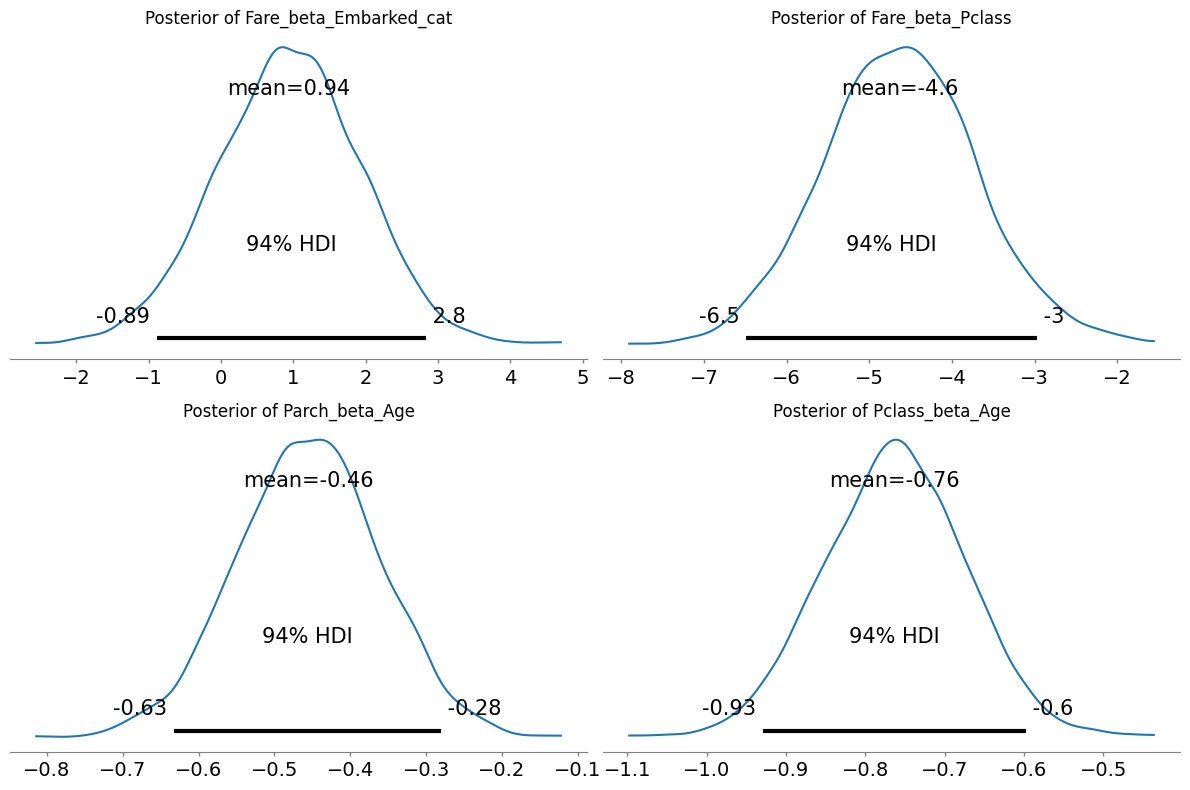


=== Learned Variable Relationships ===

                             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Fare_beta_Embarked_cat[0]   0.953  1.010  -1.018    2.765      0.028    0.037   
Fare_beta_Embarked_cat[1]  -0.298  0.954  -2.048    1.547      0.026    0.036   
Fare_beta_Pclass           -4.545  0.958  -6.173   -2.619      0.029    0.038   
Fare_intercept             39.211  2.343  34.838   43.700      0.127    0.077   
Parch_beta_Age             -0.577  0.068  -0.706   -0.450      0.011    0.007   
Parch_intercept            -1.400  0.269  -1.840   -1.049      0.175    0.026   
Pclass_beta_Age            -0.683  0.094  -0.849   -0.510      0.033    0.003   
Pclass_intercept            1.790  0.304   1.340    2.330      0.012    0.017   
SibSp_beta_Age             -0.831  0.085  -0.971   -0.675      0.042    0.006   
SibSp_intercept            -1.165  0.107  -1.402   -0.985      0.054    0.011   
Survived_beta_Age          -1.274  0.269  -1.784   -0.815      0.124

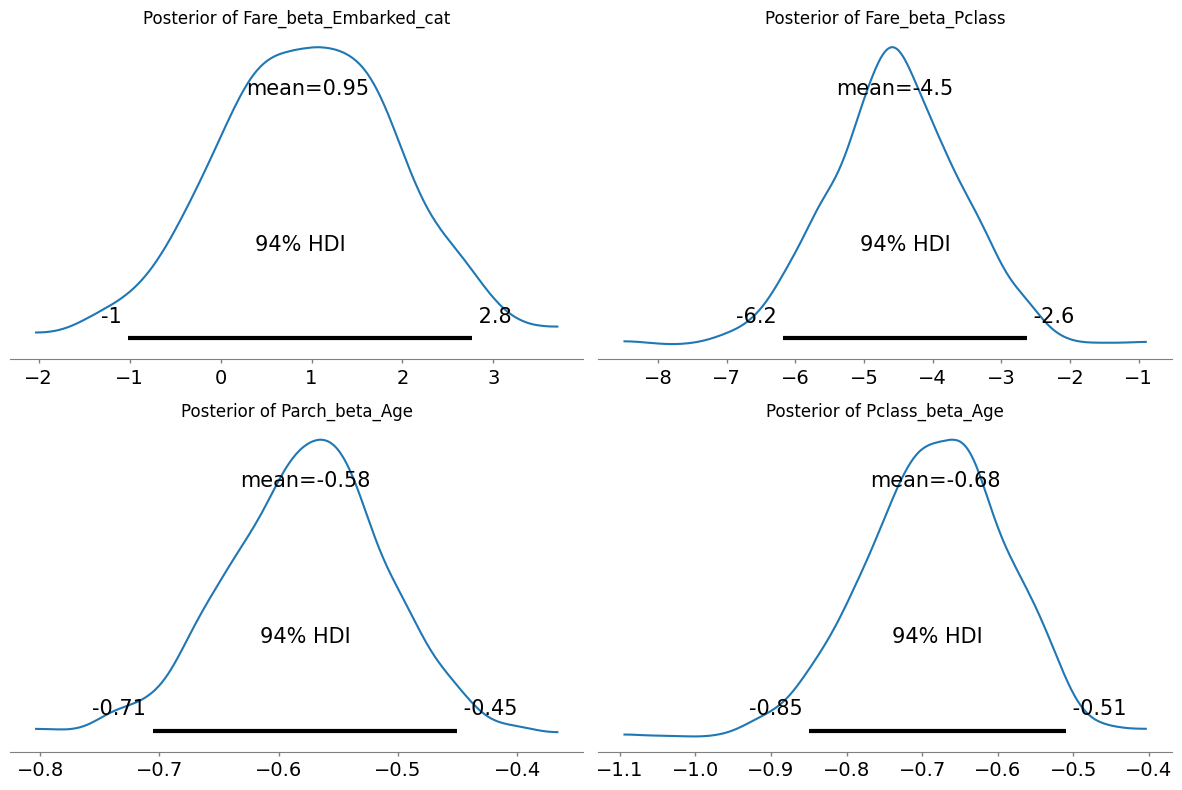

/tmp/ipython-input-40-2495999733.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=45, ha='right')  # Fixed rotation syntax
/tmp/ipython-input-40-2495999733.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=45, ha='right')  # Fixed rotation syntax
/tmp/ipython-input-40-2495999733.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(methods, rotation=45, ha='right')  # Fixed rotation syntax


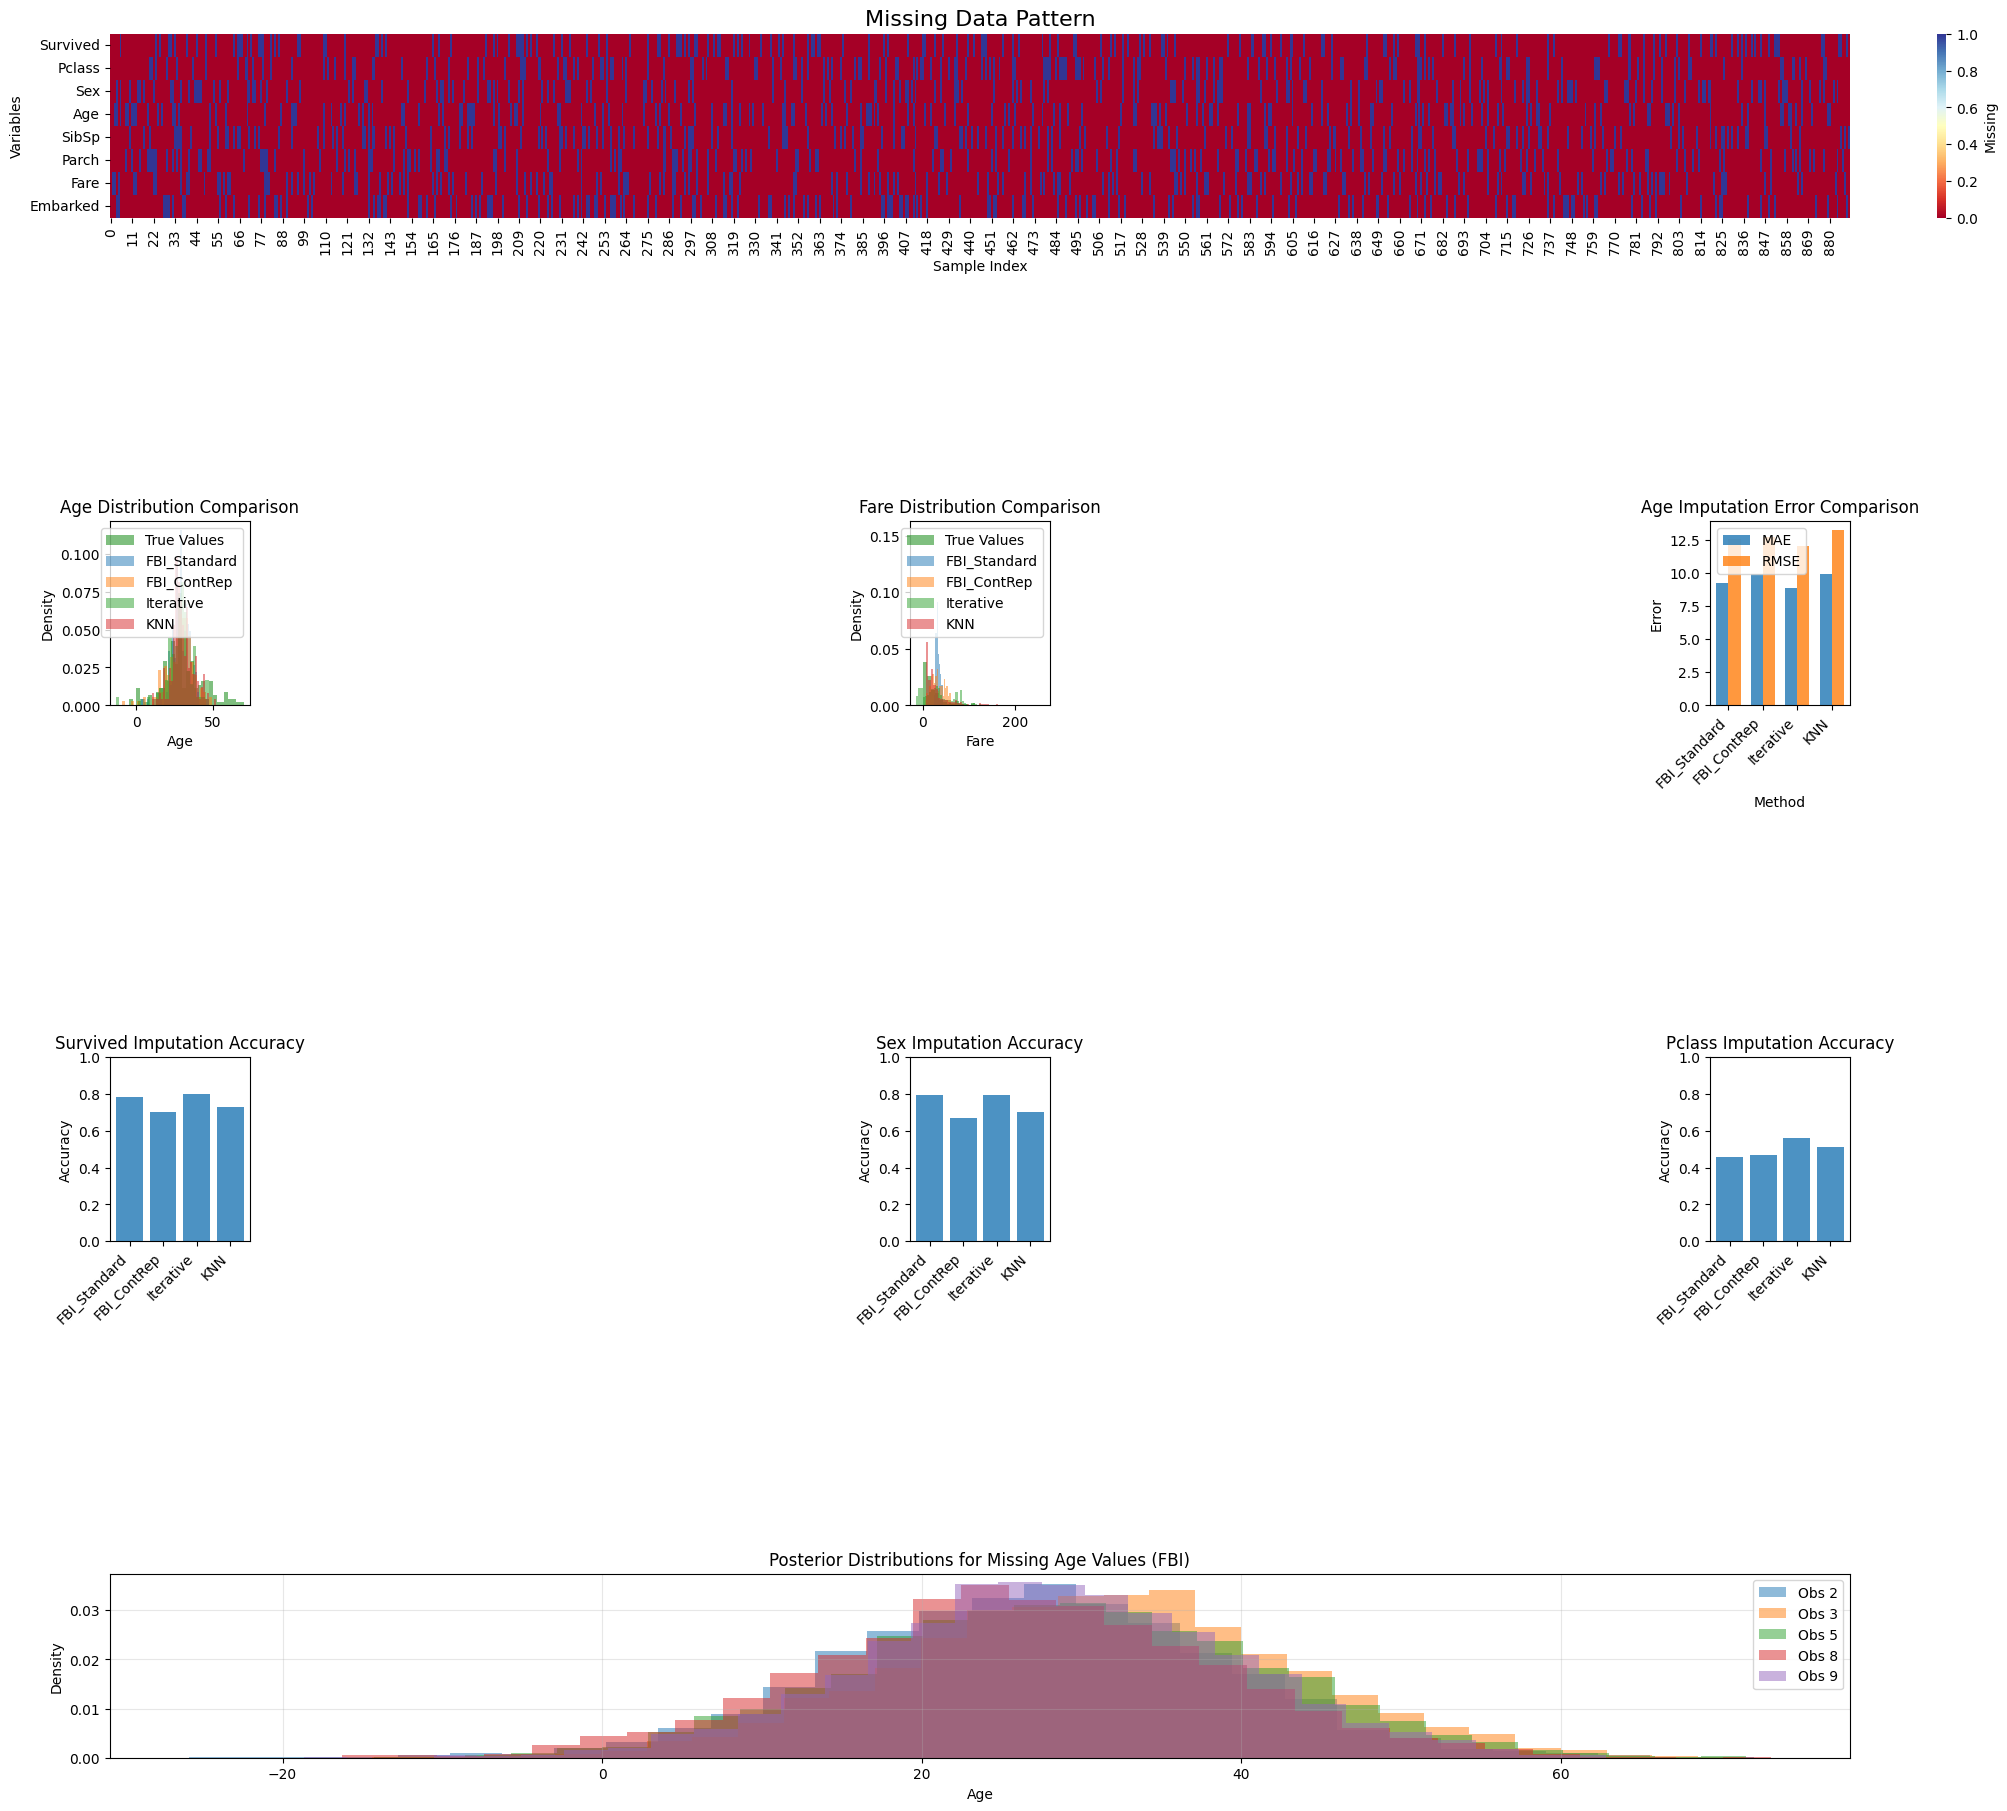


=== FBI Convergence Diagnostics ===


/tmp/ipython-input-32-4023027307.py:25: UserWarning: R-hat issues detected for <xarray.Dataset> Size: 368B
Dimensions:                 ()
Data variables: (12/46)
    Age                     int64 8B 0
    Age_mu                  int64 8B 0
    Age_mu_expanded         int64 8B 0
    Age_sigma               int64 8B 0
    Age_unobserved          int64 8B 0
    Embarked                int64 8B 4
    ...                      ...
    Survived_beta_Fare      int64 8B 0
    Survived_beta_Pclass    int64 8B 0
    Survived_beta_Sex       int64 8B 0
    Survived_intercept      int64 8B 0
    Survived_p              int64 8B 3
    Survived_unobserved     int64 8B 1 parameters
  warnings.warn(f"R-hat issues detected for {rhat_issues.sum()} parameters")
/tmp/ipython-input-32-4023027307.py:28: UserWarning: Low ESS detected for <xarray.Dataset> Size: 368B
Dimensions:                 ()
Data variables: (12/46)
    Age                     int64 8B 0
    Age_mu                  int64 8B 0
    Age_mu_exp


Number of parameters with R-hat > 1.01: <xarray.Dataset> Size: 368B
Dimensions:                 ()
Data variables: (12/46)
    Age                     int64 8B 0
    Age_mu                  int64 8B 0
    Age_mu_expanded         int64 8B 0
    Age_sigma               int64 8B 0
    Age_unobserved          int64 8B 0
    Embarked                int64 8B 4
    ...                      ...
    Survived_beta_Fare      int64 8B 0
    Survived_beta_Pclass    int64 8B 0
    Survived_beta_Sex       int64 8B 0
    Survived_intercept      int64 8B 0
    Survived_p              int64 8B 3
    Survived_unobserved     int64 8B 1
Number of parameters with ESS < 400: <xarray.Dataset> Size: 368B
Dimensions:                 ()
Data variables: (12/46)
    Age                     int64 8B 0
    Age_mu                  int64 8B 0
    Age_mu_expanded         int64 8B 0
    Age_sigma               int64 8B 0
    Age_unobserved          int64 8B 0
    Embarked                int64 8B 9
    ...              

/tmp/ipython-input-32-4023027307.py:25: UserWarning: R-hat issues detected for <xarray.Dataset> Size: 392B
Dimensions:                 ()
Data variables: (12/49)
    Age                     int64 8B 177
    Age_mu                  int64 8B 0
    Age_mu_expanded         int64 8B 0
    Age_sigma               int64 8B 1
    Age_unobserved          int64 8B 177
    Embarked                int64 8B 6
    ...                      ...
    Survived_beta_Fare      int64 8B 1
    Survived_beta_Pclass    int64 8B 1
    Survived_beta_Sex       int64 8B 1
    Survived_intercept      int64 8B 1
    Survived_omega          int64 8B 439
    Survived_p              int64 8B 869 parameters
  warnings.warn(f"R-hat issues detected for {rhat_issues.sum()} parameters")
/tmp/ipython-input-32-4023027307.py:28: UserWarning: Low ESS detected for <xarray.Dataset> Size: 392B
Dimensions:                 ()
Data variables: (12/49)
    Age                     int64 8B 178
    Age_mu                  int64 8B 0
    

In [44]:
if __name__ == "__main__":
    results, metrics = main()